# Noise Analysis of Common Emitter Amplifier with Two-Port Networks


In this notebook a technique for assembling complex two-port networks is demonstrated. The technique involves algabraically combining small primitive two-port networks to build larger networks. The final network contains a properly calculated noise covariance matrix for calculating noise parameters. Additional sections in the notebook will illustrate why this may be useful as a design tool.

Consider the two-port network containing a BJT in common-emitter configuration:

![Common-Emitter Two-Port](images/SVG/ce_2port_1.svg)

This is an AC model, so it is assumed that the transistor is biased properly. (You can imagine RF chokes at the base and collector of the transistor, which feed biasing current into the device.)

Now decompose the circuit into its primitive two-port networks. The following figure identifies three of these primitives: the transistor as a common-emmitter two-port; the degenerative resistor Re as a shunt resistor two-port; and, the feedback resistor Rf as a series resitor two-port. 

![Primitive Two-Ports](images/SVG/prims.svg)

The two capacitors on either end of the circtuit are both series capacitor two-ports. 


The circuit at the top of the page can now be viewed in its equivalent form as a combination of two-port networks:

![Equivalent Form](images/SVG/equivalent_n.svg)

Here are some observations:

1. The Rf network is parallel to the common-emmitter network,
2. That combined network is in series with the Re network,
3. The combined network in the last observation is cascaded between the Cin and Cout networks

These observations will be stated below using algebra. Consequently, we will use that algebra to construct the final network shown in the first figure.

After the complex two-port network has been constructed, the remainder of the notebook will provide examples showing where this technique might be useful.



## Setup for Simulation with scikit-rf

In this first section we do some setup. Parameters for the individual components are set here.

In [1]:

# First import the necessary libraries to do the work
import skrf as rf
import numpy as npy
from skrf.constants import *
%matplotlib inline
from pylab import * 
rf.stylely()

# Change overloaded Network operators '*', '+' and '|' to work for two-port manipulations. This
# will make it so that we can combine two-port networks using algebra.
rf.alternative_ops()

# Set the S-parameter reference impedance to 50 ohms
z0 = 50

# Specify the temperature that the measurement is being performed at
T = 300
kB = K_BOLTZMANN

# Set the range of frequencies
frequency = rf.Frequency(start=1e6, stop=10e9, npoints=401, unit='Hz', sweep_type='log')

#======================================================
#             Circuit Parameters
#======================================================

Rf = 1000     # Feedback resistance
Re = 5       # Degeneration resistance
Cinf = 1e-9    # For coupling RF into and out of the circuit

#======================================================
#             BJT Parameters
#
# These parameters can be determined from SPICE models.
# See [1].
#
# In this case a spice model for the Infineon BFP196
# was used to approximate the parameters. (The params
# are only approximate in this case because certain
# parameters such as cpi, cu, and rbb are dependant
# on bias in the Goomel-Poon model. For a better 
# approximation, a DC analysis of the circuit would
# need to be determined first (see [1]).)
#======================================================

Ic_ma = 31.4 # milliamps
beta0 = 107.7
cpi = 3.9e-12
cu = .8e-12
rbb = 5.303
rc = 0.3741
re = 0.03041
ru = 1e12 # just a large value so it doesn't matter
r0 = 1e12 # just a large value so it doesn't matter
cjx = 1e-18 # just a small value so it doesn't matter
cjs = 1e-18 # just a small value so it doesn't matter



## Creating the Primitives

The primitives are all two-port networks of type skrf.Network

In [2]:
ntwk_bjt = rf.noisyComponents.SmallSig_NPN_BJT_CE_2port(Ic_ma, beta0, cpi, cu, rbb, rc, re, ru,
                                                    r0, cjx, cjs, frequency = frequency, T0 = T)

ntwk_Rf = rf.noisyComponents.RLC_Series_2port(R = Rf, frequency=frequency, T0 = T)
ntwk_Re = rf.noisyComponents.RLC_Shunt_2port(R = Re, frequency=frequency, T0 = T)
ntwk_Cin = rf.noisyComponents.RLC_Series_2port(C = Cinf, frequency=frequency, T0 = T)
ntwk_Cout = rf.noisyComponents.RLC_Series_2port(C = Cinf, frequency=frequency, T0 = T)

## Combining Two-Port Networks
This next section of code is simply the realization of the three observations stated at the top of the notebook.

We combine the two-ports in two different ways to introduce the operators *, +, and |. 

*NOTE: to use the operators, you must call rf.alternative_ops() at the top of the script. This is
to override the default behavior of the operators.*

In [3]:
# OBSERVATION 1: ntwk_bjt is parallel to ntwk_Rf, we combine them into a single network:
ntwk_1 = rf.parallel_parallel_2port(ntwk_bjt, ntwk_Rf)

# Or, using the parallel operator:
ntwk_1 = ntwk_bjt | ntwk_Rf

# OBSERVATION 2: the resulting network from above (ntwk_1) is in series with ntwk_Re
ntwk_2 = rf.series_series_2port(ntwk_1, ntwk_Re)

# Or, using the series operator
ntwk_2 = ntwk_1 + ntwk_Re

# OBSERVATION 3: ntwk_Cin_series is cascaded with ntwk_2, which is cascaded with ntwk_Cout_series
ntwk_tmp = rf.cascade_2port(ntwk_Cin, ntwk_2)
ntwkT = rf.cascade_2port(ntwk_tmp, ntwk_Cout)
ntwkT = ntwk_2

# Or, using the two-port cascade operator
ntwkT = ntwk_Cin ** ntwk_2 ** ntwk_Cout

# since the above processes have been put into operator form, the full network 
# can be assembled in one line
ntwkT = ntwk_Cin ** ((ntwk_bjt | ntwk_Rf) + ntwk_Re) ** ntwk_Cout

# Note that the above algebra calculates both the output S-parameters and the 
# covariance matrices. From the covariance matrices noise parameters can be calculated.

## Plotting S-Parameters and Noise Parameters

ntwkT is the final combined network. We now use scikit-rf to plot the resulting S-paramters and Noise Parameters.

*These plots have been compared to simulations in QucsStudio. The results are nearly the same. rbb, cpi, and cu will are slightly different because a DC analysis isn't being performed here.*

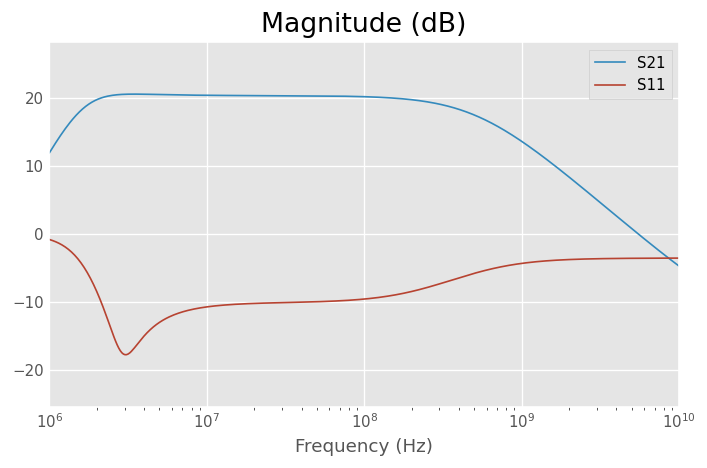

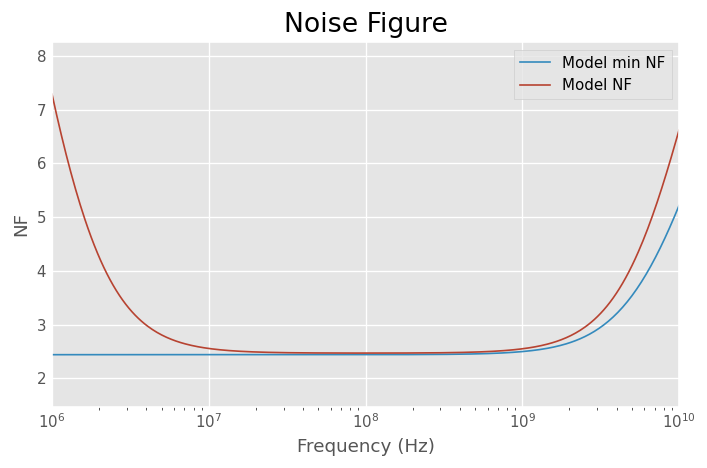

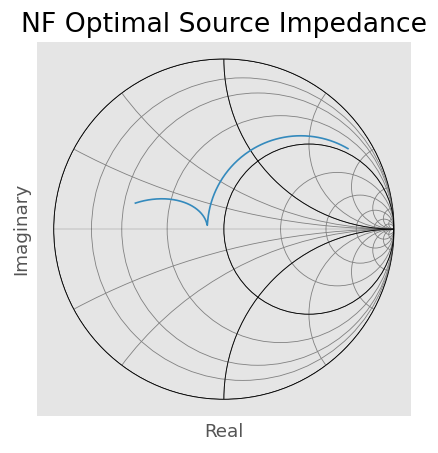

In [4]:
model_nfmin_db = ntwkT.nfmin_db
z0 = 50
model_nf_db = ntwkT.nf_db(z0)
sparams = ntwkT.s_db
npy.max(sparams)                                

from skrf.plotting import func_on_all_figs as foaf

figure(0)
title('S-Parameters')
title('Magnitude (dB)')
semilogx(frequency.f_scaled, sparams[:,1,0], label=r'S21')
semilogx(frequency.f_scaled, sparams[:,0,0], label=r'S11')
foaf(frequency.labelXAxis)
foaf(tight_layout)
foaf(legend)
tight_layout()

figure(1)
ylabel('NF')
title('Noise Figure')
semilogx(frequency.f_scaled, model_nfmin_db, label=r'Model min NF')
semilogx(frequency.f_scaled, model_nf_db, label=r'Model NF')

#ylim(1,2)
foaf(frequency.labelXAxis)
foaf(tight_layout)
foaf(legend)
tight_layout()

figure(2)
rf.plotting.plot_smith(ntwkT.g_opt, title="NF Optimal Source Impedance")

## So What?

The above simulation can be done in other packages such as QucsStudio or ADS. So why use scikit-rf to do the same thing? Having the entire structure of the simulation within a programming language provides the programmer with a lot of possibilites. Some of these possibilities are illustrated in the next sections.

## Noise Figure as a Function of Rf and Re

In this example, we place parts of the above simulation within a function. We then run the simulation at a constant frequency, but over a range of Rf and Re values. Contour plots of gain and noise figure are then generated. Finally, we use the generated plots to make design decisions. 

In [11]:

# This function simulates the circuit for a particular Rf, Re and freq. It returns the gain of the circuit and the noise figure.
def ce_circuit_s21_nf(Rf, Re, freq, ntwk_bjt, ntwk_Cin, ntwk_Cout):

    T = 300

    ntwk_Rf = rf.noisyComponents.RLC_Series_2port(R = Rf, frequency=frequency, T0 = T)
    ntwk_Re = rf.noisyComponents.RLC_Shunt_2port(R = Re, frequency=frequency, T0 = T)

    ntwkT = ntwk_Cin * ((ntwk_bjt | ntwk_Rf) + ntwk_Re) * ntwk_Cout

    return ntwkT.s_db[:,1, 0][0], ntwkT.nf_db(50)[0]

In [12]:
# Suppose we are interested in making a preamplifier for our radio that works 
# in the 20 meter ham band. We would like our gain to be about 10 dB and our 
# noise figure to be under 4 dB. Given the circuit design from above, what do we choose our
# Rf and Re to be?

freq = 14e6 # 20 meter band

# Recalculate bjt ntwork and two capacitors at the single frequency
frequency = rf.Frequency(start=freq, stop=freq, npoints=1, unit='Hz', sweep_type='log')
ntwk_bjt = rf.noisyComponents.SmallSig_NPN_BJT_CE_2port(Ic_ma, beta0, cpi, cu, rbb, rc, re, ru, r0, cjx,                                                   cjs, frequency = frequency, T0 = T)
ntwk_Cin = rf.noisyComponents.RLC_Series_2port(C = Cinf, frequency=frequency, T0 = T)
ntwk_Cout = rf.noisyComponents.RLC_Series_2port(C = Cinf, frequency=frequency, T0 = T)

# create 3D data for our gain and noise figure
NN = 20
MM = 10
rf_vec = npy.linspace(500, 5000, NN)
re_vec = npy.linspace(0.5, 100, MM)
RF, RE = npy.meshgrid(rf_vec, re_vec)
gain = npy.zeros((MM, NN))
nf = npy.zeros((MM, NN))

# in this loop we call the function from above to calculate our gain and noise figure
for n in range(0, NN):
    for m in range(0, MM):
        gain[m,n], nf[m,n] = ce_circuit_s21_nf(RF[m, n], RE[m, n], frequency, 
                                               ntwk_bjt, ntwk_Cin, ntwk_Cout)        


Text(0.5, 0, 'Rf')

<Figure size 720x480 with 0 Axes>

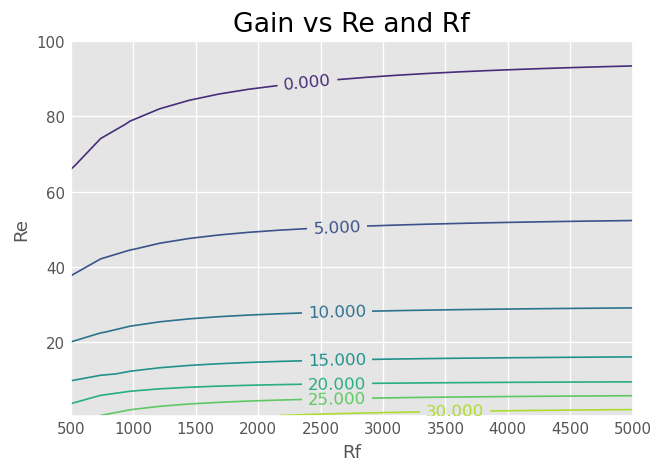

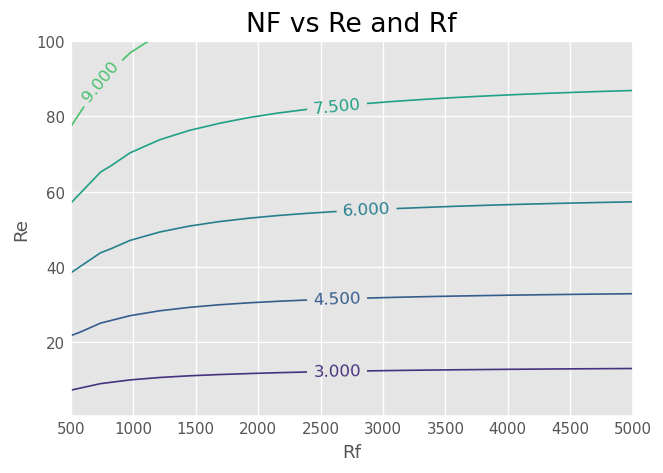

In [13]:
# Plot the contours of gain and noise figure

figure(0)
fig, ax = subplots()
CS = ax.contour(RF, RE, gain)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Gain vs Re and Rf')
ylabel('Re')
xlabel('Rf')

figure(1)
fig, ax = subplots()
CS = ax.contour(RF, RE, nf)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('NF vs Re and Rf')
ylabel('Re')
xlabel('Rf')

The plots above provide us with a map for finding values of Rf and Re. The gain contour line at 10 dB suggests a range of Rf and Re values. For example, we may choose Rf = 3000 ohms and Re = 30 ohms. If we look at this location on the Noise Figure contour, we see that we are arount 4.5 dB of noise figure. Given our design requirements, to have a noise figure under 4 dB we may need to be satisfied with a preamp that has a little more gain by reducing Re.

Gain and noise figure may not be the only constraints we are interested in. Perhaps we also want to minimize the reflection coefficient S11 looking into the circuit. 


Text(0.5, 0, 'pair index')

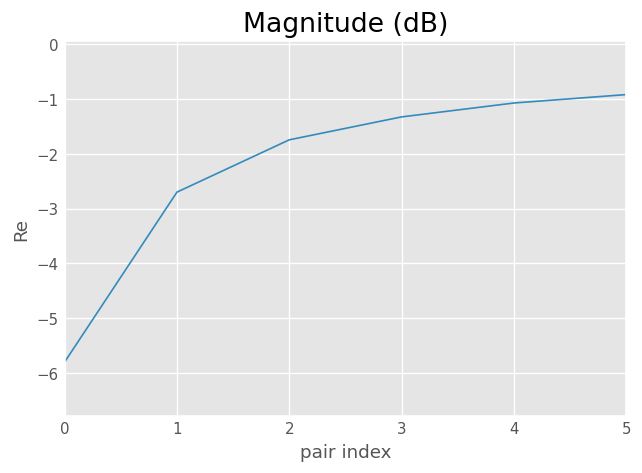

In [16]:
# Observing the contour plots above, we note that there are a set of Rf and Re values that 
# produce the roughly 10 dB of gain along with the roughly 4 dB of noise figure:

rf_re_set = [[500, 21], [1000, 26], [1500, 30], [2000, 32], [2500, 34], [3000, 35]]

# To figure out which set of these minimizes S11, we create another function:
def ce_circuit_s11(Rf, Re, freq, ntwk_bjt, ntwk_Cin, ntwk_Cout):
    T = 300
    ntwk_Rf = rf.noisyComponents.RLC_Series_2port(R = Rf, frequency=frequency, T0 = T)
    ntwk_Re = rf.noisyComponents.RLC_Shunt_2port(R = Re, frequency=frequency, T0 = T)

    ntwkT = ntwk_Cin * ((ntwk_bjt | ntwk_Rf) + ntwk_Re) * ntwk_Cout

    return ntwkT.s_db[:,0, 0][0]

# Here we loop over the pairs of resistors to generate a vector of S11 values

s11_db = npy.zeros(len(rf_re_set))
for n, pair in enumerate(rf_re_set):
    s11_db[n] = ce_circuit_s11(pair[0], pair[1], freq, ntwk_bjt, ntwk_Cin, ntwk_Cout)

# Finally we plot the values 
figure(0)
title('S11 Magnitude')
title('Magnitude (dB)')
plot(s11_db)
ylabel('Re')
xlabel('pair index')


Clearly, the lower values Rf = 500 and Re = 20 provide a better input match while maintaining 10 dB of gain and a noise figure around 4 dB. We can plug these values into the original model above to see what our S-Parameters and Noise Figure looks like.



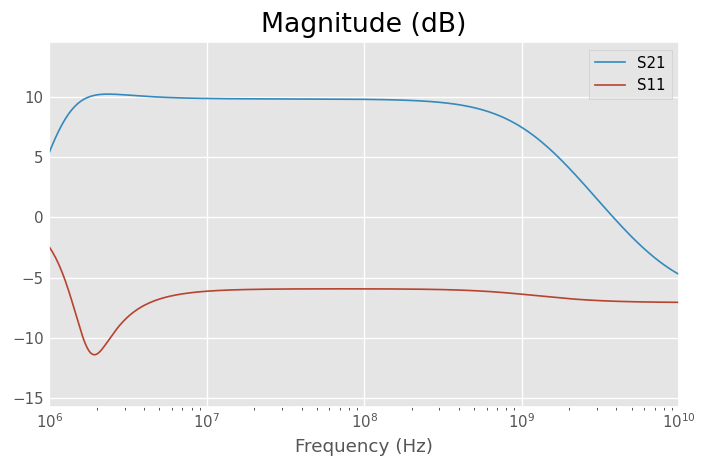

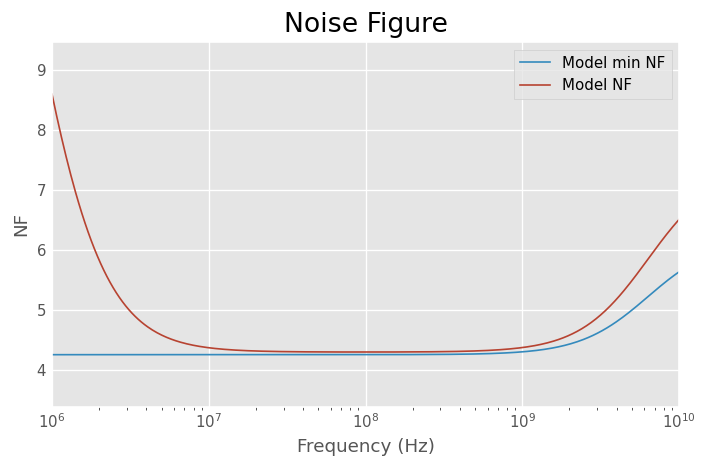

In [18]:
# Set the range of frequencies
frequency = rf.Frequency(start=1e6, stop=10e9, npoints=401, unit='Hz', sweep_type='log')

#======================================================
#             Circuit Parameters
#======================================================

Rf = 500     # Feedback resistance
Re = 20       # Degeneration resistance
Cinf = 1e-9    # For coupling RF into and out of the circuit


#======================================================
#         Two-Port Networks Instantiated
#======================================================
ntwk_bjt = rf.noisyComponents.SmallSig_NPN_BJT_CE_2port(Ic_ma, beta0, cpi, cu, rbb, rc, re, ru,
                                                    r0, cjx, cjs, frequency = frequency, T0 = T)

ntwk_Rf = rf.noisyComponents.RLC_Series_2port(R = Rf, frequency=frequency, T0 = T)
ntwk_Re = rf.noisyComponents.RLC_Shunt_2port(R = Re, frequency=frequency, T0 = T)
ntwk_Cin = rf.noisyComponents.RLC_Series_2port(C = Cinf, frequency=frequency, T0 = T)
ntwk_Cout = rf.noisyComponents.RLC_Series_2port(C = Cinf, frequency=frequency, T0 = T)

ntwkT = ntwk_Cin ** ((ntwk_bjt | ntwk_Rf) + ntwk_Re) ** ntwk_Cout

model_nfmin_db = ntwkT.nfmin_db
z0 = 50
model_nf_db = ntwkT.nf_db(z0)
sparams = ntwkT.s_db
npy.max(sparams)                                

from skrf.plotting import func_on_all_figs as foaf

figure(0)
title('S-Parameters')
title('Magnitude (dB)')
semilogx(frequency.f_scaled, sparams[:,1,0], label=r'S21')
semilogx(frequency.f_scaled, sparams[:,0,0], label=r'S11')
foaf(frequency.labelXAxis)
foaf(tight_layout)
foaf(legend)
tight_layout()

figure(1)
ylabel('NF')
title('Noise Figure')
semilogx(frequency.f_scaled, model_nfmin_db, label=r'Model min NF')
semilogx(frequency.f_scaled, model_nf_db, label=r'Model NF')

#ylim(1,2)
foaf(frequency.labelXAxis)
foaf(tight_layout)
foaf(legend)
tight_layout()


Although the above analysis was done empirically via plots, one could imagine creating a python routine to search for an optimal result based on various constraints. This is the power of simulating these circuits within a programming language that contains libraries such as numpy and scipy.

Further, suppose you desire a better match at the input of the circuit. You can imaging adding a few capacitors and inductor to the model above and then writing routines to search for values that would optimize the match.

## References
- [1] Antognetti, Paolo, Giuseppe Massobrio, and Guiseppe Massobrio. Semiconductor device modeling with SPICE. McGraw-Hill, Inc., 1993.